<a href="https://colab.research.google.com/github/BeletAntoine/Machine_Learning/blob/main/Projet1/Projet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>  Chest X-rays Detection

In [19]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import os

### 1) Download kaggle files

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We get the folder structure with the code:
```
tree -L 3 path
```

Which gives the following structure:
```
Path
└── chest_xray
    ├── chest_xray
    │   ├── test
    │   ├── train
    │   └── val
    ├── __MACOSX
    │   └── chest_xray
    ├── test
    │   ├── NORMAL
    │   └── PNEUMONIA
    ├── train
    │   ├── NORMAL
    │   └── PNEUMONIA
    └── val
        ├── NORMAL
        └── PNEUMONIA
```
Files in the NORMAL and PNEUMONIA folders are all of ".jpg" extension.

### 2) Verify the data

Using the kaggle datasets, you can usually assume the dataset will be of quality, however it's still important to know your data and verify what it looks like.

Let's check that !

In [21]:
# Get the paths for the train, test and val folders
chest_xray_path = path + "/chest_xray"
test_path = chest_xray_path + "/test"
train_path = chest_xray_path + "/train"
val_path = chest_xray_path + "/val"

In [22]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib

# Get the Normal and Pneumonia path from a  parent folder
def normal_n_pneumonia_paths(parent_folder_path):
    return (parent_folder_path + "/NORMAL"), ( parent_folder_path + "/PNEUMONIA")

# Return random images paths from the folder given
def select_random_images_from_folder(path_folder, number_images):
    list_path_images_train_normal = glob.glob(str(path_folder + "/*.jpeg"))

    array_numbers_len_list = np.arange(0, len(list_path_images_train_normal))

    # Select number_images numbers from the list
    list_random_numbers = np.random.choice(array_numbers_len_list, number_images)

    return [list_path_images_train_normal[i] for i in list_random_numbers]

# Print images from their path
def print_images_from_path(array_dim1_images_path):
    num_images = len(array_dim1_images_path)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

    if num_images == 1:  # Handle single image case
        axes = [axes]

    for ax, image_path in zip(axes, array_dim1_images_path):
        img = matplotlib.image.imread(image_path)  # Read image correctly
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Hide axes

    plt.show()

# Select random images from the folder and isplay them
def select_n_display_images_from_folder(path_folder, number_images):
    list_random_images_paths = select_random_images_from_folder(path_folder, number_images)
    print_images_from_path(list_random_images_paths)
    return list_random_images_paths


/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL


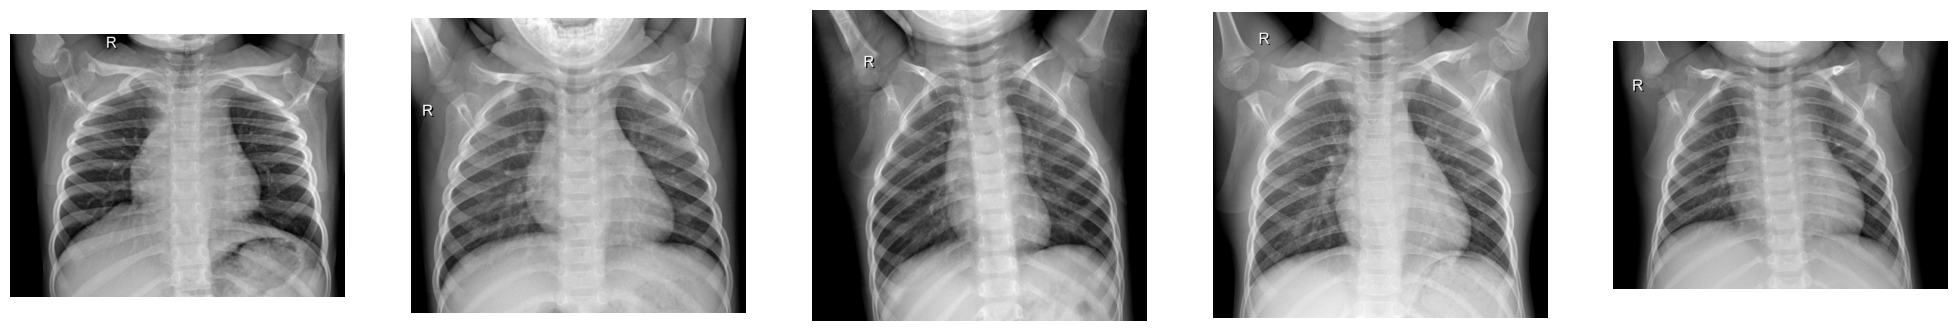

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0695-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0666-0001-0002.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0504-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1304-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0874-0001.jpeg']


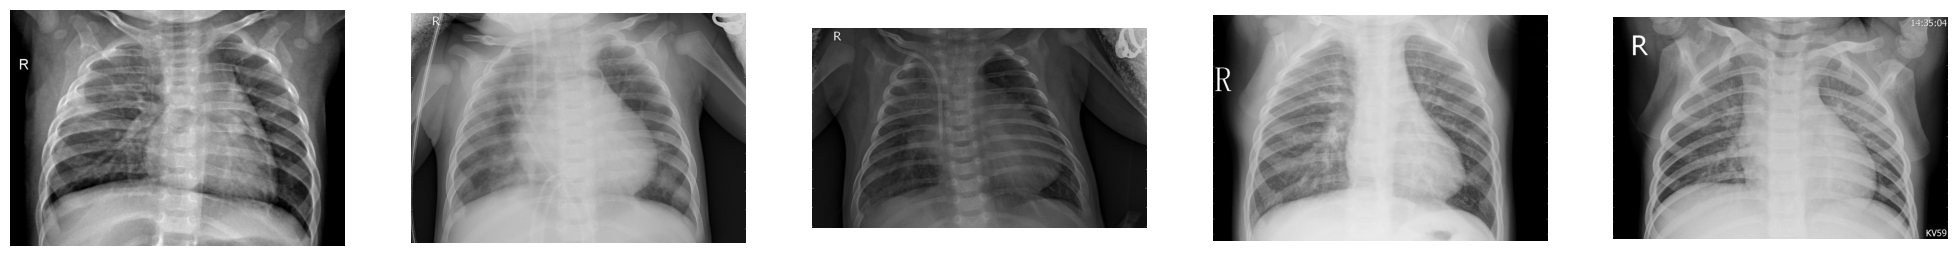

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person558_bacteria_2328.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person36_bacteria_183.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person30_bacteria_157.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person894_virus_1546.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person328_virus_681.jpeg']


In [23]:
num_images_to_display = 5

train_normal_path, train_pneumonia_path = normal_n_pneumonia_paths(train_path)
print(train_normal_path)

list_random_images_paths_normal = select_n_display_images_from_folder(train_normal_path, num_images_to_display)
print(list_random_images_paths_normal)

list_random_images_paths_pneumonia = select_n_display_images_from_folder(train_pneumonia_path, num_images_to_display)
print(list_random_images_paths_pneumonia)


### 3) Standardise the data

The data needs to have the same shape, rescaling pixel value to [0,1]

#### Reshape

In [24]:
from PIL import Image
from collections import defaultdict

# Verify the shapes existing

def count_num_images_shapes(folder_path):
    # Dictionary to count occurrences of each unique shape
    shape_counts = defaultdict(int)

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                shape = img.size  # (width, height)
                shape_counts[shape] += 1  # Count occurrences of each shape

    # Print unique shapes and their counts
    #for shape, count in shape_counts.items():
    #    print(f"Shape {shape}: {count} images")
    nb_shapes = 10
    if len(shape_counts.items()) > nb_shapes:
      print(f"There are more than {nb_shapes} different shapes in this dictionary.")

    return shape_counts

In [25]:
dictionary_shapes = count_num_images_shapes(train_normal_path)

There are more than 10 different shapes in this dictionary.


All the shapes are different, let's try ro find a shape that would work on all images, starting with the minimum shape (both width and height).

In [26]:
list_shapes = list(dictionary_shapes.keys())

# Get the min width and heigth
min_width, min_height = list(map(min, zip(*list_shapes)))
print(f"Min width: {min_width} \nMin height: {min_height}")

Min width: 912 
Min height: 672


We like powers of 2 for shapes as it works very well with maximisation of physical space, pooling steps, etc.

Let's reshape our images to (512, 512) wich is the closest power of 2 to the shapes above, and obviously it's a lower value to avoid using padding on images.

In [27]:
def resize_images_in_folder(folder_path, target_size):
    # Dictionary to store resized image variables
    resized_images = {}

    # Loop through images and resize in-memory
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)

            # Open and resize the image
            img = Image.open(file_path)
            img_resized = img.resize(target_size)  # Resize in memory

            # Store in dictionary
            resized_images[filename] = img_resized

    return resized_images

In [28]:
side_size = 64
target_size = (side_size, side_size)  # Desired shape
dict_resized_images = resize_images_in_folder(train_normal_path, target_size)

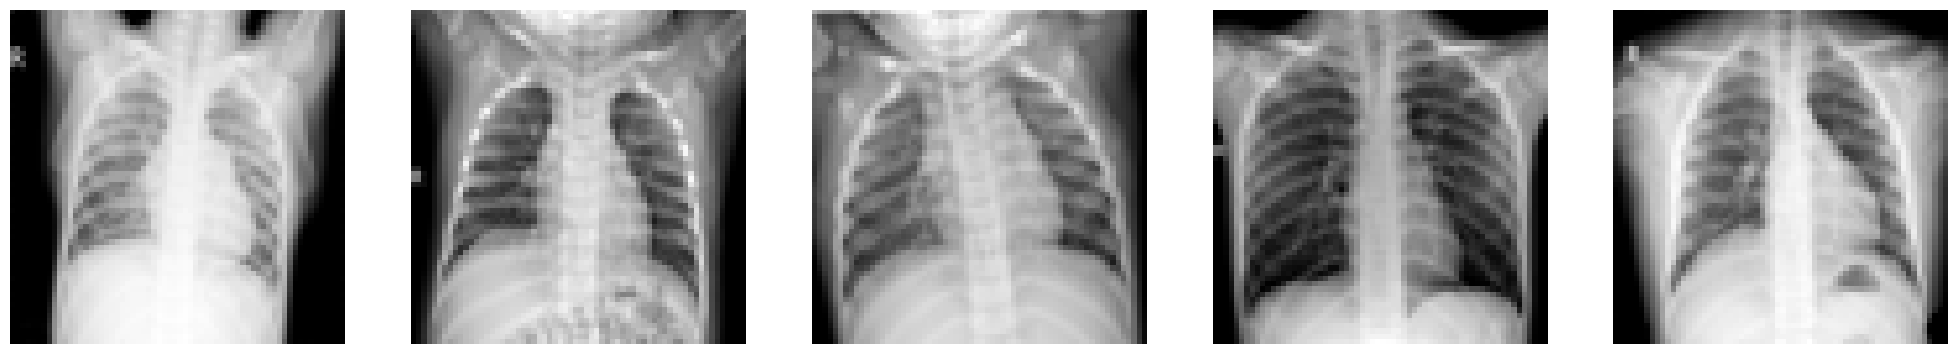

In [29]:
# Show resized images (for verification)

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

for ax, img in zip(axes, list(dict_resized_images.values())):
    ax.imshow(img, cmap="gray")
    ax.axis("off")  # Hide axes

All images seem to have been resized without any issues, let's start loading the whole dataset for training.

In [62]:
# Import the data

def get_dataset(dataset_folder_path):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_folder_path,
        image_size=target_size,
        label_mode="categorical" # Use integers labels to categorise the images
    )
    return dataset

train_dataset = get_dataset(train_path)

validation_dataset = get_dataset(val_path)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [63]:
print(type(train_dataset))
# Inspect the first few elements of the dataset
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)  # Should be (height, width, channels)
    print("Label shape:", label.shape)  # Should be (num_classes,) for one-hot encoded
    print("Label value:", label.numpy())  # Print the actual label value

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Image shape: (32, 64, 64, 3)
Label shape: (32, 2)
Label value: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


My computer has very very limited ressources, let's try to reduce the number of images.

In [64]:
import tensorflow as tf

def filter_n_images(keras_dataset, n):
    """
    Converts images to grayscale and selects the first `n` images per class.

    Args:
        keras_dataset: A TensorFlow dataset yielding (image, label) pairs.
        n: Number of images to select per class.

    Returns:
        A TensorFlow dataset containing `n` grayscale images per class.
    """
    if keras_dataset is None:
        raise ValueError("The input dataset is None. Please provide a valid dataset.")

    class_counts = {}  # Tracks the number of images selected per class
    filtered_images = []  # Stores the filtered grayscale images
    filtered_labels = []  # Stores the corresponding labels

    # Unbatch the dataset to process individual (image, label) pairs
    keras_dataset = keras_dataset.unbatch()

    for image, label in keras_dataset:
        # Labels are oen hot encoded
        label_int = tf.argmax(label, axis=-1).numpy().item()  # Convert to integer

        # Check if we need more images for this class
        if class_counts.get(label_int, 0) < n:
            # Convert image to grayscale
            if len(image.shape) == 4:  # Batch dimension present
                image = image[0]  # Remove batch dimension
            grayscale_image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
            filtered_images.append(grayscale_image)
            filtered_labels.append(label_int)
            class_counts[label_int] = class_counts.get(label_int, 0) + 1

        # Stop if we have enough images for all classes
        if all(count >= n for count in class_counts.values()):
            break

    # Convert lists to tensors
    filtered_images = tf.stack(filtered_images)  # Stack images into a single tensor
    filtered_labels = tf.convert_to_tensor(filtered_labels, dtype=tf.int32)

    # Create a dataset from the filtered images and labels
    dataset = tf.data.Dataset.from_tensor_slices((filtered_images, filtered_labels))

    return dataset


nb_images = 10

# Assuming train_dataset is already defined
train_dataset = filter_n_images(train_dataset, nb_images)

In [55]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [67]:
# Batch the dataset before inspection
batch_size = 4  # Choose an appropriate batch size
batched_dataset = train_dataset.batch(batch_size)

# Check dataset
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, height, width, 1)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    print("Unique labels in batch:", tf.unique(labels).y.numpy())  # Check unique labels in the batch

Images shape: (64, 64, 1)
Labels shape: ()


InvalidArgumentError: {{function_node __wrapped__Unique_device_/job:localhost/replica:0/task:0/device:CPU:0}} unique expects a 1D vector. [Op:Unique] name: 

In [32]:
label_counts = {0: 0, 1: 0}
for images, labels in train_dataset:
    for label in labels.numpy():
        label_counts[label] += 1
print("Label counts:", label_counts)

Label counts: {0: 10, 1: 10}


### 4) Creation of model

In [33]:
import keras
from keras import layers

def basic_CNN_model(input_shape, nb_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x) # Picture of shape (256,256) after
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x) # It's 256 because the shape of the image at that stage is (256,256)
    outputs = layers.Dense(nb_classes , activation="sigmoid")(x) # We return the probability of belinging to a certain class
    return keras.Model(inputs, outputs)

### 5) Training

In [34]:
input_shape = (side_size, side_size, 1)  # Desired shape
nb_classes = 1
epochs = 10
batch_size = 1

model = basic_CNN_model(input_shape,nb_classes)

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=batch_size,
    validation_data=validation_dataset,
    verbose=1
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - acc: 0.3390 - loss: 13.1925

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d_1" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 64, 64, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Access history data
print(history.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history.history['loss'])  # Prints loss values per epoch
print(history.history['acc'])  # Prints accuracy values per epoch

In [ ]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()